In [46]:
# pandas, cx_Oracle, datetime 라이브러리 호출
import pandas as pd
import numpy as np
import cx_Oracle
import datetime

In [47]:
# EdCSV 클래스 생성 (csv파일들을 합친 뒤, 필요 컬럼들만 추출한 csv파일을 저장하고 리턴)
class EdCSV :
    # 필요컬럼을 담는 멤버필드
    cols = None

    # 생성자
    def __init__(self) :
        pass
        
    # 멤버메소드
    #  *args로 여러 개의 데이터프레임을 파라미터로 받음
    def mergedf(self, *args) :
        merged_df = None
        # 받은 데이터프레임을 합치는 for문
        for df in args :
            # 첫 번째 데이터프레임을 merged_df로 설정
            if df.equals(args[0]) :
                merged_df = df
                continue
            # 필요컬럼들만 추출하고 합치기
            merged_df = pd.concat([merged_df[self.cols], df[self.cols]], ignore_index=True)
        # date 컬럼을 기준으로 오름차순 정렬
        merged_df.sort_values(by = 'date', inplace=True)
        # 필터링한 데이터프레임을 csv파일로 저장
        merged_df.to_csv('C:\\data\\merged_file.csv', index=False)
        merged_csv = 'C:\\data\\merged_file.csv'
        # 필터링된 csv파일을 리턴
        return merged_csv

In [48]:
# EdDB 클래스 생성 (CSV파일을 읽고 DB에 저장)
class EdDB :
    # 멤버필드
    con = None
    cur = None
    
    # 생성자
    def __init__(self) :
        pass

    # 멤버메소드
    def insertDB(self, csv) :
        # DB에 연결하고 입력하는 con, cur 생성
        self.con = cx_Oracle.connect("Scott/tiger@localhost:1521/xe")
        self.cur = self.con.cursor()
        # 파라미터로 받은 CSV파일 읽어오기
        df = pd.read_csv(csv)
        # 행 개수 만큼 반복
        for i in range(len(df)) :
            if df.iloc[i]['location'] == 'South Korea' :
                # 한국식별코드생성
                data0 = "KR" + df.iloc[i]['date'].replace("-", "")
            elif df.iloc[i]['state'] == 'HI' :
                # 하와이식별코드생성
                data0 = "HI" + df.iloc[i]['date'].replace("-", "")
            else :
                # 미국식별코드생성
                data0 = "US" + df.iloc[i]['date'].replace("-", "")
            date_str = df.iloc[i]['date']
            # date컬럼 값을 '연도-월-일' 날짜 타입으로 변경
            date_data = datetime.datetime.strptime(date_str, '%Y-%m-%d')
            data1 = self.cur.var(cx_Oracle.TIMESTAMP)
             # data1에 날짜값 넣기
            data1.setvalue(0, date_data)
            # data2에 국가이름 넣기
            data2 = df.iloc[i]['location']
            # 주 이름이 있으면 넣고 없으면 None
            if pd.isna(df.iloc[i]['state']) :
                data3 = None
            else :
                data3 = df.iloc[i]['state']
            # 총 확진자수 값이 있으면 넣고 없으면 None
            if pd.isna(df.iloc[i]['total_cases']) :    
                data4 = None
            else :
                data4 = int(df.iloc[i]['total_cases'])
            # 인구수 값이 있으면 넣고 없으면 None
            if pd.isna(df.iloc[i]['population']) :
                data5 = None
            else :
                data5 = int(df.iloc[i]['population'])
             
            # sql문 생성
            sql = "INSERT INTO covid VALUES(:1, :2, :3, :4, :5, :6)"
            # sql문 실행
            self.cur.execute(sql, (data0, data1.getvalue(), data2, data3, data4, data5))

        self.con.commit()      # 데이터 저장
        self.cur.close()       # 커서 종료
        self.con.close()       # 연결 종료

In [49]:
# 시각화 클래스 생성
class Visualization :
    # 생성자
    def __init__(self) :
        pass

    # 시각화 메소드
    def visual(self, csv1, csv2) :
        # csv파일들을 읽어오기
        df1 = pd.read_csv(csv1)
        df2 = pd.read_csv(csv2)
        # 국가 비율 구하기
        rate = round((df1.iloc[0]['POPULATION'] / df2.iloc[0]['POPULATION']), 2)

        # 날짜를 인덱스로 설정
        df1.set_index('SUBMISSION_DATE', inplace = True)
        df2.set_index('SUBMISSION_DATE', inplace = True)

        # 날짜 기준으로 오름차순 정렬
        df1.sort_values(by='SUBMISSION_DATE', inplace=True)
        df2.sort_values(by='SUBMISSION_DATE', inplace=True)

        # 총확진자수만 추출
        df1_total_cases = df1['TOT_CASES']
        df2_total_cases = df2['TOT_CASES']

        # 시각화용 데이터프레임 생성
        final_df = pd.DataFrame({
            'KOR': df1_total_cases, 
            'HI': df2_total_cases * rate
        }, index=df1_total_cases.index)

        # 데이터 시각화
        final_df.plot.line(rot=45)

In [50]:
# DB에서 원하는 데이터를 추출 후 csv파일로 만드는 함수
def selectDB(filename, table, location, startday, endday) :
    conn = cx_Oracle.connect("Scott/tiger@localhost:1521/xe")
    if location != 'Hawaii' :
        query = f"SELECT * FROM {table} WHERE location = '{location}' AND state is null AND submission_date BETWEEN '{startday}' AND '{endday}'"
    else :
        query = f"SELECT * FROM {table} WHERE state = 'HI' AND submission_date BETWEEN '{startday}' AND '{endday}'"       
    df = pd.read_sql(query, conn)
    df.to_csv('C:\\data\\' + filename + '.csv', index=False)
    csvfile = 'C:\\data\\' + filename + '.csv'
    conn.close()
    return csvfile

In [51]:
# csv파일들을 필터링하는 함수
def filterCSV(covidcsv, hawaiicsv) :
    # 데이터프레임으로 읽어오기
    raw_df = pd.read_csv(covidcsv)
    hi_df = pd.read_csv(hawaiicsv)
    # 데이터프레임의 컬럼명 맞추기
    hi_df = hi_df.rename(columns = {'tot_cases' : 'total_cases'})
    # state 컬럼이 없으면 생성
    if 'state' not in raw_df.columns:
        raw_df['state'] = np.nan
    if 'state' not in hi_df.columns:
        hi_df['state'] = np.nan
    # 하와이 인구수
    hi_df['population'] = 1433336
    # 하와이 국가 이름
    hi_df['location'] = 'United States'
    # date컬럼에 datetime 함수 적용
    raw_df['date'] = pd.to_datetime(raw_df['date'])
    hi_df['date'] = pd.to_datetime(hi_df['submission_date'])
    # 한국과 미국 데이터만 추출
    krus_df = raw_df[raw_df.location.isin(['South Korea', 'United States'])]

    # 필터링한 데이터프레임 리턴
    return krus_df, hi_df

In [52]:
            ## 메인코드 부분 ##
# 코로나 데이터(csv), 하와이 코로나 데이터(csv)
covid_csv ='C:\\data\\owid-covid-data.csv'
hawaii_covid_csv = 'C:\\data\\hawaii-covid-data.csv'

In [53]:
# FilterCSV 함수에 2개의 csv파일을 넣고 리턴값 받기
df1, df2 = filterCSV(covid_csv, hawaii_covid_csv)

In [54]:
# EdCSV 객체 생성
newCSV = EdCSV()
# 필요컬럼들을 객체의 필드값으로 저장
newCSV.cols = ['date', 'location', 'state', 'total_cases', 'population']
# 두 데이터프레임을 파라미터로 넣고 메소드 실행
merged_csv = newCSV.mergedf(df1, df2)

In [55]:
# edDB 객체 생성
myDB = EdDB()
# 필터링된 CSV파일을 파라미터로 넣고 메소드 실행
myDB.insertDB(merged_csv)

In [56]:
# DB에서 원하는 데이터를 csv파일로 가져오기
kor_csv = selectDB(filename = 'korData', 
                   table = 'covid', 
                   location = 'South Korea', 
                   startday = '2022-01-01', 
                   endday = '2022-07-21')

hi_csv = selectDB(filename = 'hiData',
                  table = 'covid',
                  location = 'Hawaii',
                  startday = '2022-01-01',
                  endday = '2022-07-21')

C:\Users\user\AppData\Local\Temp\ipykernel_23460\2171102014.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


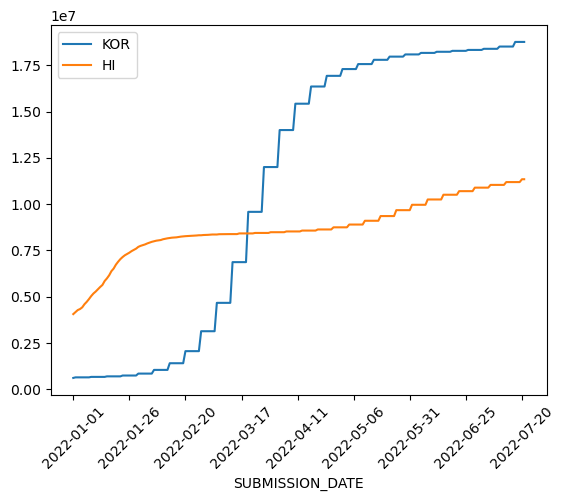

In [57]:
# Visualization 객체 생성
my_visual = Visualization()
# 비교할 csv파일들을 넣고 시각화 함수 실행
my_visual.visual(kor_csv, hi_csv)